# Notebook to test the interpolator.
Objectives:
1. Verify that the interpolator accurately recovers the metric data at the grid points used to create the interpolant.
2. Ensure the interpolation is smooth, guaranteeing the existence and finiteness of differentials.
3. Measure the computation time of the interpolator.

### Vaishak's script

In [1]:
import h5py, numpy as np
import config
import time

config.conf_matplolib()
import sys

sys.path.append("/mnt/pfs/vaishak.p/Projects/Codes/custom_libraries/sxstools")
from sxstools.transforms import (
    GetSphereRadialExtents,
    GetDomainRadii,
    ToCartesian,
)
from config import verbosity

tverb = verbosity.levels()
tverb.set_print_verbosity(2)
from spectral.spherical.grids import GLGrid
import mpi4py
from mpi4py import MPI
from waveformtools.waveformtools import message
from spectral.interpolation.interpolate_new import Interpolate3D
from pathlib import Path
from sxstools.data_loader import SXSDataLoader

mpi_comm = MPI.COMM_WORLD
# rank = comm.Get_rank()
# size = comm.Get_size()
mpi_nprocs = mpi_comm.Get_size()
mpi_rank = mpi_comm.Get_rank()

/mnt/pfs/vaishak.p/Projects/Codes/custom_libraries/waveformtools/waveformtools
No module named 'pycbc'
/mnt/pfs/vaishak.p/Projects/Codes/custom_libraries/spectral/spectral
print verbosity has been set to 2 at /mnt/pfs/vaishak.p/Projects/Codes/custom_libraries/config/config/__init__.py


--------------------------------------------------------------------------

  Local host:   sonic7
  Local device: mlx5_0
--------------------------------------------------------------------------


In [2]:
tt1 = time.time()

run_dir = (
    "/mnt/pfs/anuj.mishra/spec_runs/test_runs/test_dumptensor_3/Ev/Lev1_AA/Run"
)

# Number of time steps
n_t_steps = 1
index = 0

##########################################################
# Load grid structure
#####################
dl = SXSDataLoader(
    run_dir=run_dir,
    subdomain="SphereC0",
    metric_dir="PsiKappa",
)

dl.load_grid_structure()


##################################################################################
# Load volume four metric
##########################


input_data = []

for t_step in range(1, n_t_steps + 1):
    input_data.append(dl.get_four_metric(t_step=t_step, component="tt"))

input_data = np.array(input_data)
message(f"Raw data shape {input_data.shape}")


r_grid = dl.r_min * np.ones(dl.AngularGrid.shape)

tmp_data = h5py.File(run_dir + "/PsiKappa/DumpedMetricData_SphereC0.h5")
n_radii, n_theta, n_phi = tmp_data["psi"]["Step000000"].attrs["Extents"]

Ntime 9 	 N_radii 15 N_theta 14 N_phi 28


Available radii data dict_keys(['SphereC'])
Raw data shape (1, 15, 14, 28)


In [3]:
# diff_data = []
# for index_x in np.arange(n_theta)[:]:
#     for index_y in np.arange(n_phi)[:]:

#         one_set_of_coords = np.array(
#             [
#                 [
#                     r_grid[index_x, index_y],
#                 ],
#                 [
#                     dl.theta_grid[index_x, index_y],
#                 ],
#                 [
#                     dl.phi_grid[index_x, index_y],
#                 ],
#             ]
#         )

# # constructed as a list of (list of) coordinates
# sphp_output_grid_list = np.array(
#     [
#         one_set_of_coords
#     ]
# )

In [4]:
index_x, index_y = 0, 0
one_set_of_coords = np.array(
    [
        [r_grid[index_x, index_y], r_grid[index_x, index_y]],
        [dl.theta_grid[index_x, index_y], dl.theta_grid[index_x, index_y]],
        [dl.phi_grid[index_x, index_y], dl.phi_grid[index_x, index_y]],
    ]
)

# constructed as a list of (list of) coordinates
sphp_output_grid_list = np.array(
    [
        one_set_of_coords,
    ]
)

In [5]:
sphp_output_grid_list

array([[[38.92801292, 38.92801292],
        [ 0.16581714,  0.16581714],
        [ 0.        ,  0.        ]]])

In [6]:
########################################################
# Interpolate
##############

# Initialize context
interp3d = Interpolate3D(
    sphp_output_grid=sphp_output_grid_list,
    raw_data=input_data,
    r_min=dl.r_min,
    r_max=dl.r_max,
    run_dir=run_dir,
    sxs_data_loader=dl,
)

###################################################
# Construct interpolant

interp3d.construct_interpolant()

if mpi_rank == 0:
    all_zeros = (interp3d.interpolant.modes_data == 0).all()

# Evaluate interpolant
interp3d.evaluate_interpolant()

# diff = float((interp3d.interpolated_data[index].real - input_data[index][0][index_x, index_y])[0].real)
# r, t, p = r_grid[index_x, index_y], dl.theta_grid[index_x, index_y], dl.phi_grid[index_x, index_y]
# diff_data.append([index_x, index_y,
#                   r, t, p,
#                   *ToCartesian([r, t, p]),
#                   diff])

# diff_data = np.asarray(diff_data)
# # np.savetxt("/mnt/pfs/anuj.mishra/projects/nr_gw_tidal_dissipation/interpolation_test_1.dat", diff_data)
# tt2 = time.time()
# print(f"Time to compute interpolant at {len(diff_data)} points: {tt2-tt1:.2f}s")
# print(f"Computation time per grid point: {(tt2-tt1)/len(diff_data):.2f}s")

The raw data has a time axis.Assuming the leading axisto be the time axis
Engine using 1 processors
In pre-setup 
	Number of time steps 1
	Number of radial shells 15
	Angular grid shape 14 x 28
	Num of radial points 15
	L grid of expansion 13
Computing logical collocation points
Done
	Loading in Inertial SPHP Output Grid and transforming to Comoving frame...
The output grid (each coord) shape is  (2,)
Rotation angles are [-6.35758741e-05  9.88734029e-03  1.98378897e-02  2.97761218e-02
  3.96958955e-02  4.95932897e-02  5.94616057e-02  6.92865997e-02
  7.90540261e-02  8.87648675e-02  9.84340512e-02  1.08079271e-01
  1.17715375e-01  1.27352978e-01  1.36998444e-01  1.46654691e-01
  1.56322508e-01  1.66001991e-01  1.75693758e-01  1.85399684e-01
  1.95123067e-01  2.04868294e-01  2.14640160e-01  2.24443074e-01
  2.34280363e-01  2.44153823e-01  2.54063584e-01  2.64008256e-01
  2.73985307e-01  2.83991547e-01  2.94023611e-01  3.04078306e-01
  3.14152756e-01  3.24244478e-01  3.34351460e-01  3.444

Interpolating element 1 of 15 
Interpolating element 2 of 15 
Interpolating element 3 of 15 
Interpolating element 4 of 15 
Interpolating element 5 of 15 
Interpolating element 6 of 15 
Interpolating element 7 of 15 
Interpolating element 8 of 15 
Interpolating element 9 of 15 
Interpolating element 10 of 15 
Interpolating element 11 of 15 
Interpolating element 12 of 15 
Interpolating element 13 of 15 
Interpolating element 14 of 15 
Gathering modes r 
Total number of local angular decompositionjobs 15
Reorganize modes in t and r 
list length: (15)
Fectching all Clm modes at time step 0
Finished expanding radial shells in angular modes...
Expanding angular modes in Chebyshev spectrum...
Len of stacked Clm_r modes list  15
This Clm_r modes data shape (15, 196)
Computing ToSpec
Done
This Clmr shape (15, 196)
list length: (1)
Len of job_output 1
Len of job output[0] 2
job output[0] [0, array([[-3.40319595e+00+0.00000000e+00j,  1.16874514e-11-1.35008179e-11j,
        -6.88185176e-11+0.000

In [7]:
interp3d.coords_groups_list

[[[array([38.92801292, 38.92801292]),
   array([0.16581714, 0.16581714]),
   array([6.35758741e-05, 6.35758741e-05])]]]

In [7]:
interp3d.interpolated_data

[array([(-0.9504790524909912+2.163067945637073e-23j),
        (-0.9504790524909912+2.163067945637073e-23j)], dtype=object)]

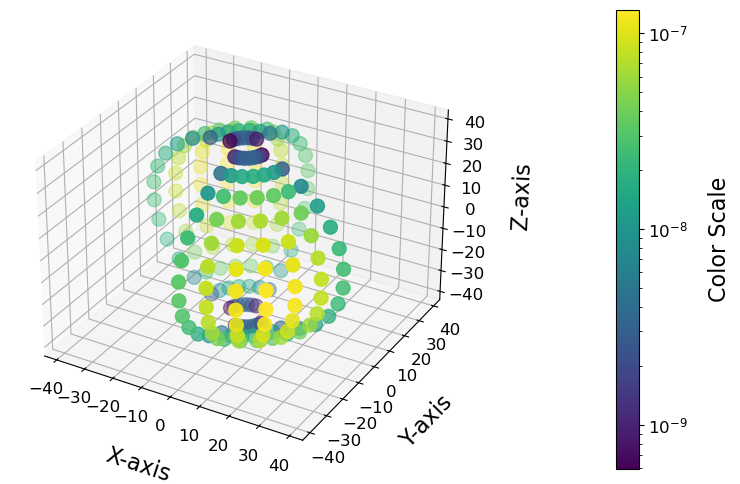

In [27]:
# %matplotlib notebook

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

diff_data = np.loadtxt(
    "/mnt/pfs/anuj.mishra/projects/nr_gw_tidal_dissipation/interpolation_test_1.dat"
)
x, y, z, c = diff_data[:, [-4, -3, -2, -1]].T

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111, projection="3d")
sc = ax.scatter(
    x,
    y,
    z,
    c=c,
    s=100,
    cmap="viridis",
    marker="o",
    norm=matplotlib.colors.LogNorm(),
)

ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")

cbar = plt.colorbar(sc, ax=ax, pad=0.1)
cbar.set_label("Color Scale")
plt.savefig(
    "/mnt/pfs/anuj.mishra/projects/nr_gw_tidal_dissipation/interpolation_test_1.png",
    facecolor="w",
    bbox_inches="tight",
    dpi=300,
)
plt.show()

### Test of Smoothness: varying r for fixed theta and phi

In [52]:
import h5py, numpy as np
import config
import time

config.conf_matplolib()
import sys

sys.path.append("/mnt/pfs/vaishak.p/Projects/Codes/custom_libraries/sxstools")
from sxstools.transforms import (
    GetSphereRadialExtents,
    GetDomainRadii,
    ToCartesian,
)
from config import verbosity

tverb = verbosity.levels()
tverb.set_print_verbosity(2)
from spectral.spherical.grids import GLGrid
import mpi4py
from mpi4py import MPI
from waveformtools.waveformtools import message
from spectral.interpolation.interpolate_new import Interpolate3D
from pathlib import Path
from sxstools.data_loader import SXSDataLoader

mpi_comm = MPI.COMM_WORLD
# rank = comm.Get_rank()
# size = comm.Get_size()
mpi_nprocs = mpi_comm.Get_size()
mpi_rank = mpi_comm.Get_rank()

tt1 = time.time()

run_dir = "/mnt/pfs/anuj.mishra/spec_runs/test_runs/test_dumptensor_3/Ev/Lev1_AA/Run/"

# Number of time steps
n_t_steps = 1
index = 0

##########################################################
# Load grid structure
#####################
dl = SXSDataLoader(
    run_dir=run_dir,
    subdomain="SphereC0",
    metric_dir="PsiKappa",
)

dl.load_grid_structure()


##################################################################################
# Load volume four metric
##########################


input_data = []

for t_step in range(1, n_t_steps + 1):
    input_data.append(dl.get_four_metric(t_step=t_step, component="tt"))

input_data = np.array(input_data)
message(f"Raw data shape {input_data.shape}")


r_grid = dl.r_min * np.ones(dl.AngularGrid.shape)

tmp_data = h5py.File(run_dir + "/PsiKappa/DumpedMetricData_SphereC0.h5")
n_radii, n_theta, n_phi = tmp_data["psi"]["Step000000"].attrs["Extents"]
filed = run_dir + "GrDomain.input"
radii_dict = GetDomainRadii(filed)
subdomain = "SphereC0"
r_min, r_max = GetSphereRadialExtents(radii_dict, sub_domain=subdomain)

s_data = []
index_x, index_y = 10, 10
for r in np.linspace(r_min, r_max, 100):
    one_set_of_coords = np.array(
        [
            [
                r,
            ],
            [
                dl.theta_grid[index_x, index_y],
            ],
            [
                dl.phi_grid[index_x, index_y],
            ],
        ]
    )

    # constructed as a list of (list of) coordinates
    sphp_output_grid_list = np.array([one_set_of_coords])

    ########################################################
    # Interpolate
    ##############

    # Initialize context
    interp3d = Interpolate3D(
        sphp_output_grid=sphp_output_grid_list,
        raw_data=input_data,
        r_min=dl.r_min,
        r_max=dl.r_max,
        run_dir=run_dir,
        sxs_data_loader=dl,
    )

    ###################################################
    # Construct interpolant

    interp3d.construct_interpolant()

    if mpi_rank == 0:
        all_zeros = (interp3d.interpolant.modes_data == 0).all()

    # Evaluate interpolant
    interp3d.evaluate_interpolant()

    t, p = dl.theta_grid[index_x, index_y], dl.phi_grid[index_x, index_y]
    s_data.append(
        [
            index_x,
            index_y,
            r,
            t,
            p,
            *ToCartesian([r, t, p]),
            np.float64(np.real(interp3d.interpolated_data[index][index])),
        ]
    )

s_data = np.asarray(s_data)
np.savetxt(
    "/mnt/pfs/anuj.mishra/projects/nr_gw_tidal_dissipation/interpolation_test_2_smoothness.dat",
    s_data,
)
tt2 = time.time()
print(f"Time to compute interpolant at {len(s_data)} points: {tt2-tt1:.2f}s")
print(f"Computation time per grid point: {(tt2-tt1)/len(s_data):.2f}s")

print verbosity has been set to 2 at /home/anuj.mishra/git_repos/vaishak/config/config/__init__.py
Ntime 9 	 N_radii 15 N_theta 14 N_phi 28
Available radii data dict_keys(['SphereC'])
Raw data shape (1, 15, 14, 28)
The raw data has a time axis.Assuming the leading axisto be the time axis
Engine using 1 processors
In pre-setup 
	Number of time steps 1
	Number of radial shells 15
	Angular grid shape 14 x 28
	Num of radial points 15
	L grid of expansion 13
Computing logical collocation points
Done
	Loading in Inertial SPHP Output Grid and transforming to Comoving frame...
The output grid (each coord) shape is  (1,)
Rotation angles are [-6.35758741e-05  9.88734029e-03  1.98378897e-02  2.97761218e-02
  3.96958955e-02  4.95932897e-02  5.94616057e-02  6.92865997e-02
  7.90540261e-02  8.87648675e-02  9.84340512e-02  1.08079271e-01
  1.17715375e-01  1.27352978e-01  1.36998444e-01  1.46654691e-01
  1.56322508e-01  1.66001991e-01  1.75693758e-01  1.85399684e-01
  1.95123067e-01  2.04868294e-01  2

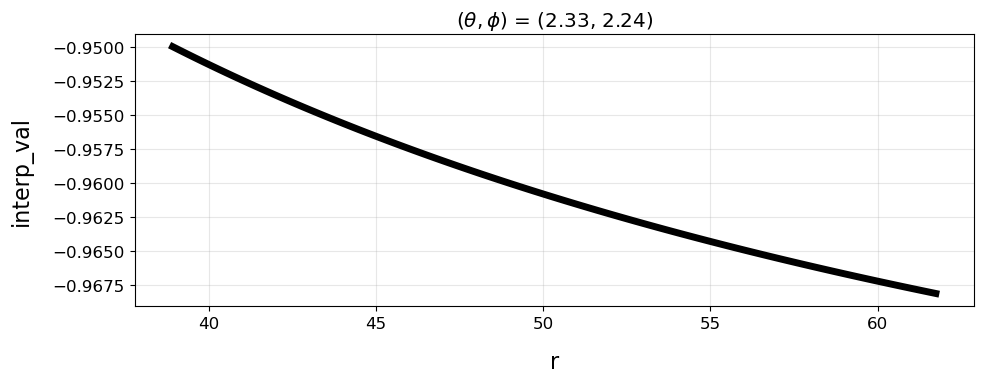

In [75]:
# %matplotlib notebook

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

s_data = np.loadtxt(
    "/mnt/pfs/anuj.mishra/projects/nr_gw_tidal_dissipation/interpolation_test_2_smoothness.dat"
)
r, ii = s_data[:, [2, -1]].T
t, p = s_data[0][[3, 4]]

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(r, ii, color="black", linewidth=5)
# ax.scatter(r, ii, s=100, marker='o', color="r")

ax.set_xlabel("r")
ax.set_ylabel("interp_val")
ax.set_title(rf"$(\theta, \phi)$ = ({t:.2f}, {p:.2f})")
plt.savefig(
    "/mnt/pfs/anuj.mishra/projects/nr_gw_tidal_dissipation/interpolation_test_2_smoothness.png",
    facecolor="w",
    bbox_inches="tight",
    dpi=300,
)
plt.show()

In [83]:
import h5py, numpy as np
import config
import time

config.conf_matplolib()
import sys

sys.path.append("/mnt/pfs/vaishak.p/Projects/Codes/custom_libraries/sxstools")
from sxstools.transforms import (
    GetSphereRadialExtents,
    GetDomainRadii,
    ToCartesian,
)
from config import verbosity

tverb = verbosity.levels()
tverb.set_print_verbosity(2)
from spectral.spherical.grids import GLGrid
import mpi4py
from mpi4py import MPI
from waveformtools.waveformtools import message
from spectral.interpolation.interpolate_new import Interpolate3D
from pathlib import Path
from sxstools.data_loader import SXSDataLoader

mpi_comm = MPI.COMM_WORLD
# rank = comm.Get_rank()
# size = comm.Get_size()
mpi_nprocs = mpi_comm.Get_size()
mpi_rank = mpi_comm.Get_rank()

tt1 = time.time()

run_dir = "/mnt/pfs/anuj.mishra/spec_runs/test_runs/test_dumptensor_3/Ev/Lev1_AA/Run/"

# Number of time steps
n_t_steps = 1
index = 0

##########################################################
# Load grid structure
#####################
dl = SXSDataLoader(
    run_dir=run_dir,
    subdomain="SphereC0",
    metric_dir="PsiKappa",
)

dl.load_grid_structure()


##################################################################################
# Load volume four metric
##########################


input_data = []

for t_step in range(1, n_t_steps + 1):
    input_data.append(dl.get_four_metric(t_step=t_step, component="tt"))

input_data = np.array(input_data)
message(f"Raw data shape {input_data.shape}")


r_grid = dl.r_min * np.ones(dl.AngularGrid.shape)

tmp_data = h5py.File(run_dir + "/PsiKappa/DumpedMetricData_SphereC0.h5")
n_radii, n_theta, n_phi = tmp_data["psi"]["Step000000"].attrs["Extents"]
filed = run_dir + "GrDomain.input"
radii_dict = GetDomainRadii(filed)
subdomain = "SphereC0"
r_min, r_max = GetSphereRadialExtents(radii_dict, sub_domain=subdomain)

s_data = []
t, p = 0, 0
for r in np.linspace(r_min, r_max, 10):
    one_set_of_coords = np.array(
        [
            [
                r,
            ],
            [
                t,
            ],
            [
                p,
            ],
        ]
    )

    # constructed as a list of (list of) coordinates
    sphp_output_grid_list = np.array([one_set_of_coords])

    ########################################################
    # Interpolate
    ##############

    # Initialize context
    interp3d = Interpolate3D(
        sphp_output_grid=sphp_output_grid_list,
        raw_data=input_data,
        r_min=dl.r_min,
        r_max=dl.r_max,
        run_dir=run_dir,
        sxs_data_loader=dl,
    )

    ###################################################
    # Construct interpolant

    interp3d.construct_interpolant()

    if mpi_rank == 0:
        all_zeros = (interp3d.interpolant.modes_data == 0).all()

    # Evaluate interpolant
    interp3d.evaluate_interpolant()

    s_data.append(
        [
            index_x,
            index_y,
            r,
            t,
            p,
            *ToCartesian([r, t, p]),
            np.float64(np.real(interp3d.interpolated_data[index][index])),
        ]
    )

s_data = np.asarray(s_data)
np.savetxt(
    "/mnt/pfs/anuj.mishra/projects/nr_gw_tidal_dissipation/interpolation_test_2_smoothness_v3.dat",
    s_data,
)
tt2 = time.time()
print(f"Time to compute interpolant at {len(s_data)} points: {tt2-tt1:.2f}s")
print(f"Computation time per grid point: {(tt2-tt1)/len(s_data):.2f}s")

print verbosity has been set to 2 at /home/anuj.mishra/git_repos/vaishak/config/config/__init__.py
Ntime 9 	 N_radii 15 N_theta 14 N_phi 28
Available radii data dict_keys(['SphereC'])
Raw data shape (1, 15, 14, 28)
The raw data has a time axis.Assuming the leading axisto be the time axis
Engine using 1 processors
In pre-setup 
	Number of time steps 1
	Number of radial shells 15
	Angular grid shape 14 x 28
	Num of radial points 15
	L grid of expansion 13
Computing logical collocation points
Done
	Loading in Inertial SPHP Output Grid and transforming to Comoving frame...
The output grid (each coord) shape is  (1,)
Rotation angles are [-6.35758741e-05  9.88734029e-03  1.98378897e-02  2.97761218e-02
  3.96958955e-02  4.95932897e-02  5.94616057e-02  6.92865997e-02
  7.90540261e-02  8.87648675e-02  9.84340512e-02  1.08079271e-01
  1.17715375e-01  1.27352978e-01  1.36998444e-01  1.46654691e-01
  1.56322508e-01  1.66001991e-01  1.75693758e-01  1.85399684e-01
  1.95123067e-01  2.04868294e-01  2

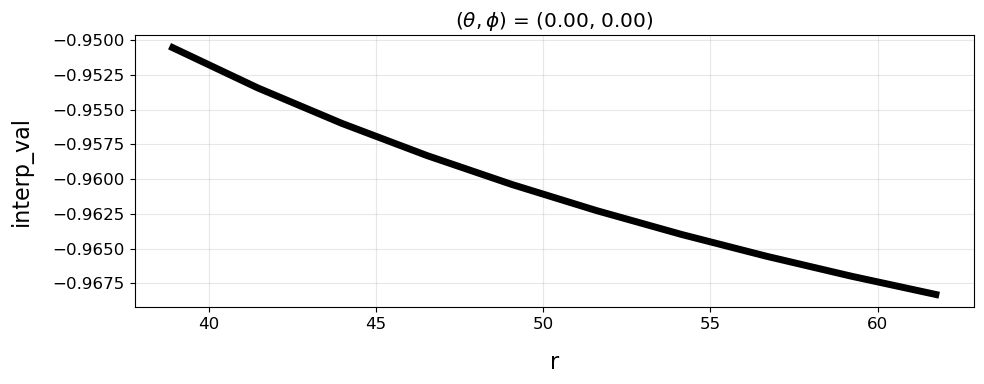

In [86]:
# %matplotlib notebook

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

s_data = np.loadtxt(
    "/mnt/pfs/anuj.mishra/projects/nr_gw_tidal_dissipation/interpolation_test_2_smoothness_v3.dat"
)
r, ii = s_data[:, [2, -1]].T
t, p = s_data[0][[3, 4]]

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(r, ii, color="black", linewidth=5)
# ax.scatter(r, ii, s=100, marker='o', color="r")

ax.set_xlabel("r")
ax.set_ylabel("interp_val")
t, p = 0, 0
ax.set_title(rf"$(\theta, \phi)$ = ({t:.2f}, {p:.2f})")
# plt.savefig("/mnt/pfs/anuj.mishra/projects/nr_gw_tidal_dissipation/interpolation_test_2_smoothness.png", facecolor="w", bbox_inches="tight", dpi=300)
plt.show()